# DROPSINATOR


## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from lmfit.models import GaussianModel

from scipy.signal import find_peaks
from scipy import optimize as optim

import uncertainties as unc


import sys
sys.path.append('../Library')

import drop_detection_tools as ddt
import uplotlib as uplt


plot_dir = '../../../Report/Plots/'
plot_dir.rstrip('/')

from importlib import reload


from tqdm import tqdm
%matplotlib inline
import csv

## Latex plot

In [2]:
FontSize = 18
plt.rc('axes',   titlesize = FontSize) # fontsize of the axes title
plt.rc('axes',   labelsize = FontSize) # fontsize of the x and y labels
plt.rc('xtick',  labelsize = FontSize) # fontsize of the tick labels
plt.rc('ytick',  labelsize = FontSize) # fontsize of the tick labels
plt.rc('legend', fontsize  = FontSize) # legend fontsize
plt.rc('figure', titlesize = FontSize) # fontsize of the figure title

matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.size' :  18,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Data acquisition

../Library\drop_detection_tools.py:54: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(loc='best')


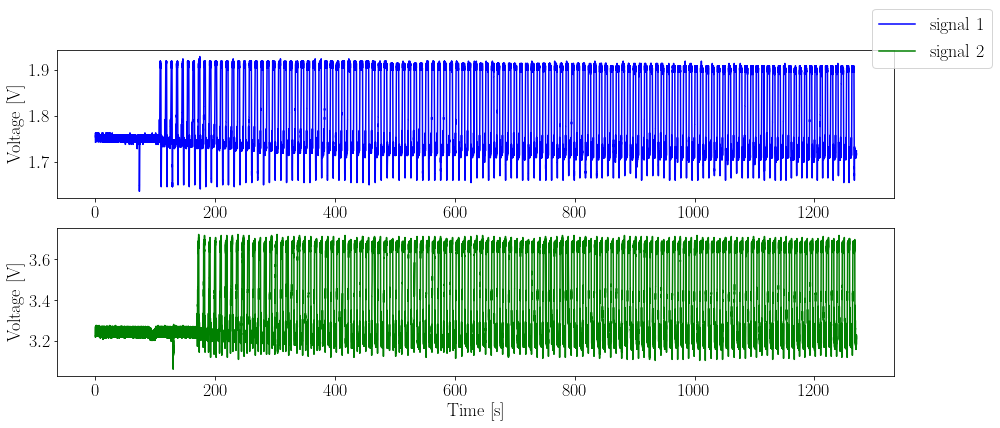

In [3]:
#************************************
folder   = '../../../T-data/2-12/'
filename = 'B-ol2-aq2-pause10.csv'
name     = '2-12_B-ol15-aq15'
#************************************

raw = True 
sig1, sig2, t_raw = ddt.read_LV(folder, filename)

## Resample data

<ipython-input-5-2c55b89d88de>:22: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(loc='best')


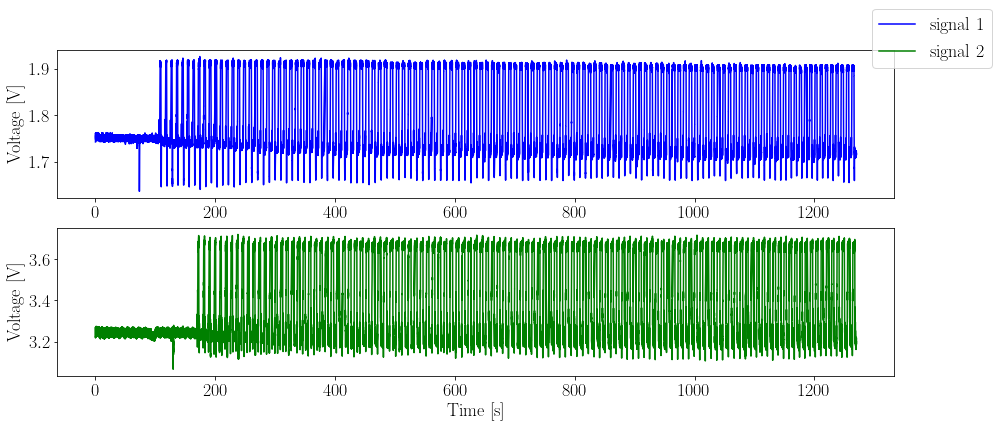

In [5]:
#******************************
dt = 0.01  # sampling time [s]
#******************************

# Resampling of the two signals
if raw:
    sig1, new_t = ddt.resample(sig1, t_raw, dt=dt)
    sig2, _     = ddt.resample(sig2, t_raw, dt=dt)
    t           = new_t
    raw         = False 
else:
    print('data already resampled')

    
# Signals plots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,6))
axs[0].plot(t, sig1, color='blue', label= "signal 1")
axs[0].set_ylabel('Voltage [V]')
axs[1].plot(t, sig2, color='green', label= "signal 2")
axs[1].set_ylabel('Voltage [V]')
axs[1].set_xlabel('Time [s]')
fig.legend(loc='best')

## Fourier transform


In [6]:
min_freq  = 1       # lower cut-off frequency
max_freq  = 19000   # higher cut-off frequency

### Signal 1 

E:\Programmi\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
E:\Programmi\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
../Library\drop_detection_tools.py:290: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  legend = fig.legend(['original signal','cropped signal'], loc='best')


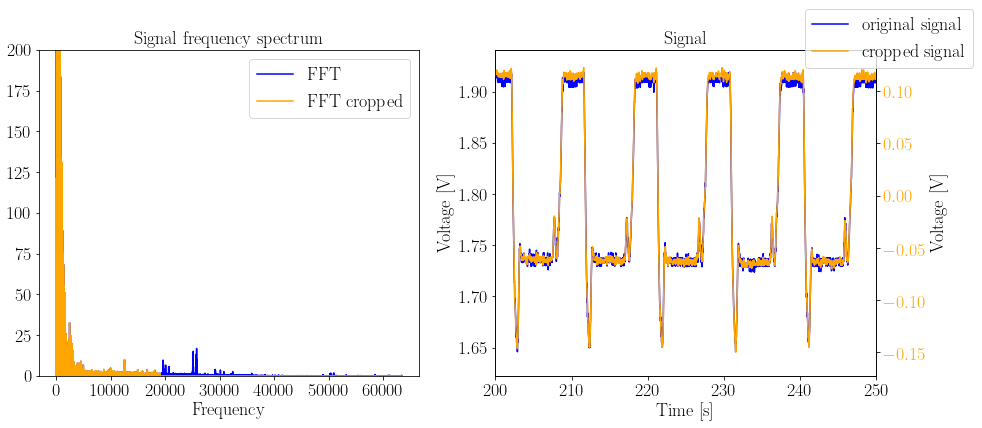

In [7]:
sig1_high = ddt.FFT_cropping(sig1, t, min_freq, max_freq, Xmin=200, Xmax=250)

### Signal 2 

E:\Programmi\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
E:\Programmi\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
../Library\drop_detection_tools.py:290: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  legend = fig.legend(['original signal','cropped signal'], loc='best')


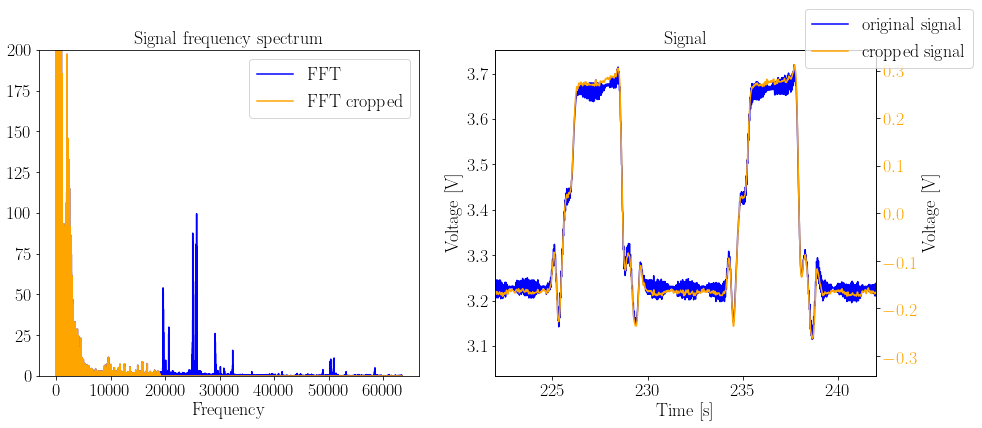

In [12]:
sig2_high = ddt.FFT_cropping(sig2, t, min_freq, max_freq, Xmin=222, Xmax=242)

## Signal Rectify

### Signal 1 

100%|████████████████████████████████████████████████████████████████████████| 126992/126992 [00:36<00:00, 3502.68it/s]


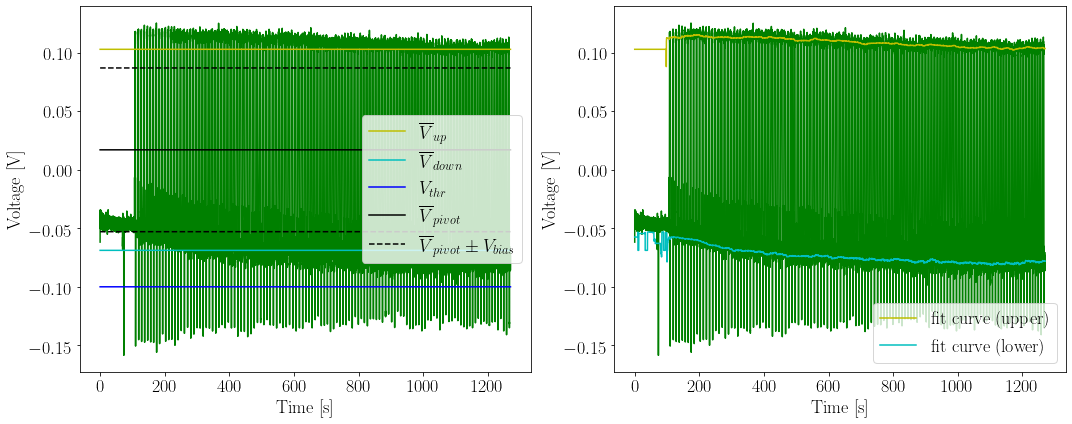

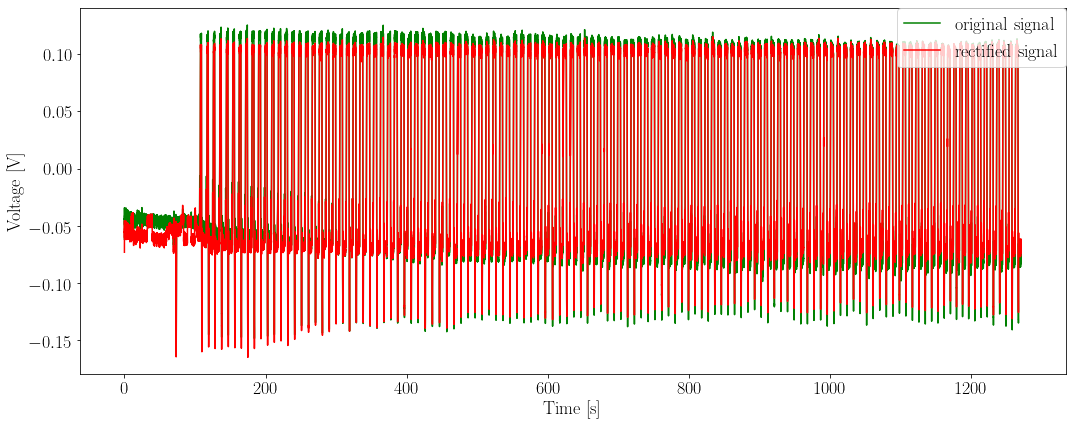

In [13]:
%matplotlib inline

fig, sig1_r = ddt.rectify_new(sig1_high, xrange=10, xdata=t, ignore_bias=0.07, manual_thr=-0.1)

### Signal 2

100%|████████████████████████████████████████████████████████████████████████| 126992/126992 [00:36<00:00, 3484.82it/s]


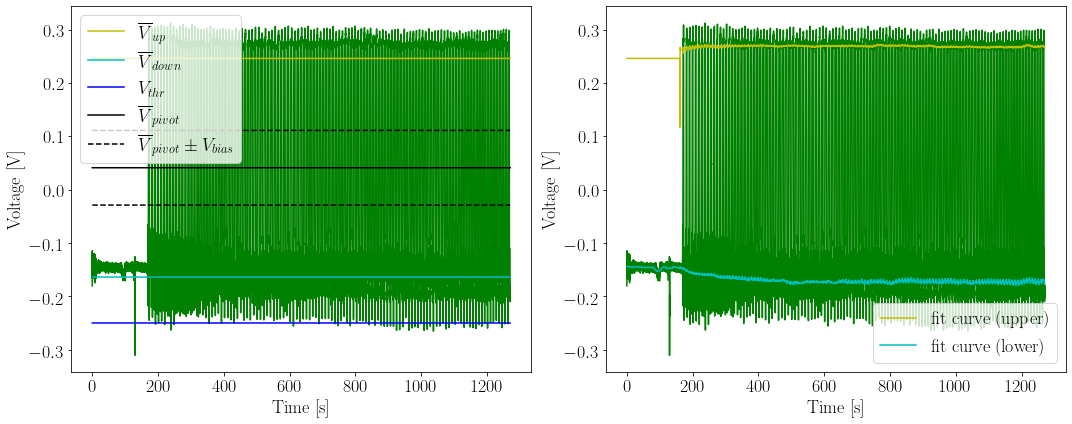

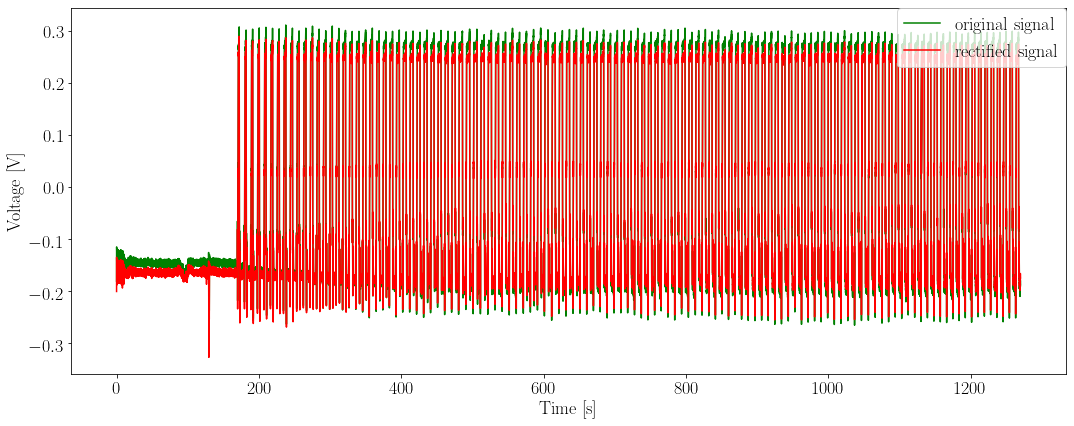

In [14]:
fig, sig2_r = ddt.rectify_new(sig2_high, xrange=10, xdata=t, ignore_bias=0.07, manual_thr=-0.25)

## Thresholds computing

In [17]:
# THRESHOLDS SEARCHING FUNCTION 
def thr_searcher(Ydata, nbins=20, low_sigmas=3, high_sigmas=3, c01=None, c02=None, plot_switch=True, Xdata=None, **kwargs):
    
    '''
    Description:
        Oscillating data finds the two threshold to identify peaks (droplets)
    
    Params:
        - Ydata:       array with oscillating data
        - nbins:       number of bins for the histogram to find the two thresholds
        - low_sigmas:  number of sigmas above the low mean where to put the lower thr
        - high_sigmas: number of sigmas below the high mean where to put the higher thr
        
        - plot_switch: if True shows plots
        - Xdata:       array with the matching time (or space) to the data
        
        **kwargs:
            - ymin, ymax:  ylims for the plot
            - xlabel
            - ylabel
            - figsize
        
    Returns:
        thr_low, thr_high
    '''
    
    xlabel = kwargs.pop('xlabel',None)
    ylabel = kwargs.pop('ylabel',None)
    ymin = kwargs.pop('ymin', None)
    ymax = kwargs.pop('ymax', None)
    xmin = kwargs.pop('xmin', None)
    xmax = kwargs.pop('xmax', None)
    figsize = kwargs.pop('figsize', (15, 6))
    
    if xlabel is None:
        xlabel = 'Position [mm]'
    if ylabel is None:
        ylabel = 'Luminosity'
    
    if plot_switch:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        freq,bins,p = axes[0].hist(Ydata, nbins, **kwargs)
    
    # Histogram definition
    else:
        freq,bins,p = plt.hist(Ydata, nbins, color='green')
    x = 0.5 *(bins[:-1] + bins[1:])
    max_freq = np.max(freq)                                     
        
    # Gaussian 1
    gauss1 = GaussianModel(prefix='g1_')
    pars   = gauss1.make_params(center=x[0]+(x[-1]-x[0])/10, sigma=(x[-1]-x[0])/15 , amplitude=max(freq))

    # Gaussian 2
    gauss2 = GaussianModel(prefix='g2_')
    pars.update(gauss2.make_params())
    
    if c01 is None:
        # Gaussian 1 parameters
        pars['g1_center'].set(max = x[0]+(x[-1]-x[0])*0.7, min=min(x))
        #pars['g1_sigma'].set(max=(x[-1]-x[0])/10, min=(x[-1]-x[0])/30)
        #pars['g1_amplitude'].set(value=max(freq)/20,min=10)
    else:
        pars['g1_center'].set(value = c01)

    # Gaussian 2 parameters
    if c02 is None:
        c02 = x[-1]-(x[-1]-x[0])/10
        
    pars['g2_center'].set(value=c02)
    pars['g2_sigma'].set(value=(x[-1]-x[0])/15)
    pars['g2_amplitude'].set(value=max(freq))

    mod  = gauss1 + gauss2
    init = mod.eval(pars, x=x)
    out  = mod.fit(freq, pars, x=x)

    
    if plot_switch:
        # Plot histo
        #axes[0].plot(x, out.init_fit, 'k--', label='initial fit')
        axes[0].plot(x, out.best_fit, 'r-', label='best fit')
        axes[0].legend(loc='best')
        axes[0].set_title("Signal histogram")
        axes[0].set_xlabel(ylabel)
        axes[0].set_ylabel("Number of events")
        
        if axes[0].get_ylim()[1] > 1.5*max_freq:
            axes[0].set_ylim(0,1.5*max_freq)

    center2 = out.best_values.get('g2_center')
    sigma2  = out.best_values.get('g2_sigma')
    center1 = out.best_values.get('g1_center')
    sigma1  = out.best_values.get('g1_sigma')

    
    max_freq1 = max(freq[x<center1+sigma1])
    x_max1    = x[np.argmax(freq[x<center1+2*sigma1])]
    max_freq2 = max(freq[x>center2-sigma2])
    a         = x > center2-sigma2
    freq2     = np.zeros(len(freq))
    for i in range(len(a)): 
        if a[i]==True: freq2[i]=freq[i]
    x_max2 = x[np.argmax(freq2)]
       
    # Thresholds computing
    thr_low  = x_max1 + low_sigmas *sigma1
    thr_high = x_max2 - high_sigmas*sigma2
    
    # Labels
    label_low  = "thr. low (" + str(low_sigmas) + "$\sigma$)"
    label_high = "thr. high (" + str(high_sigmas) + "$\sigma$)"
    
    # Signal plot
    if plot_switch:
        axes[0].vlines([thr_low], *axes[0].get_ylim(), color='cyan')
        axes[0].vlines([thr_high], *axes[0].get_ylim(), color='yellow')
        
        if Xdata is None:
            Xdata = np.arange(len(Ydata))
        
        axes[1].plot(Xdata, Ydata, **kwargs)
        axes[1].plot(thr_high*np.ones(len(Xdata)), color='yellow', label=label_low)
        axes[1].plot(thr_low *np.ones(len(Xdata)), color='cyan', label=label_high)
        plt.legend()
        plt.xlim((0, Xdata[len(Xdata)-1]))
        if not (ymin is None or ymax is None):
            axes[1].set_ylim(ymin, ymax)
        if not (xmin is None or xmax is None):
            axes[1].set_xlim(xmin, xmax)
        axes[1].set_title("Signal with thresholds")
        axes[1].set_xlabel(xlabel)
        axes[1].set_ylabel(ylabel)
        
    if thr_low > thr_high:
        print('WARNING: thr_low > thr_high')
    
    return thr_low, thr_high, sigma1, sigma2 # sigma1 is the lower one

### Signal 1

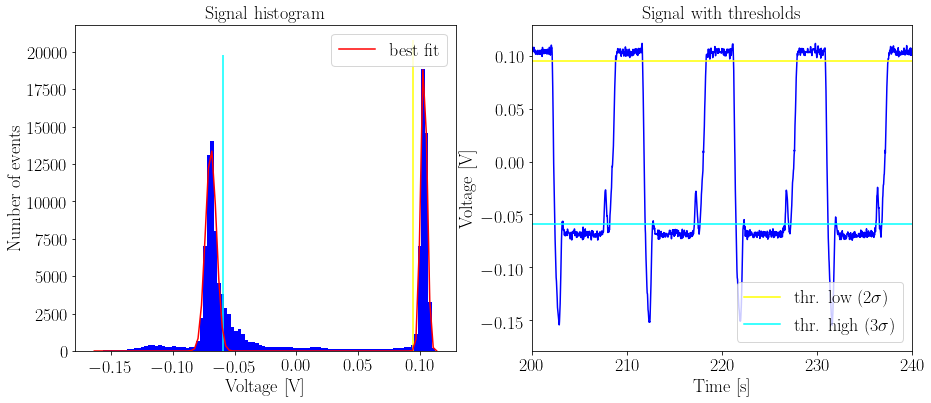

In [19]:
%matplotlib inline
thr_low_1, thr_high_1, sigma_low_1, sigma_high_1 = thr_searcher(sig1_r, 100, high_sigmas=3, low_sigmas=2, Xdata=t,
                                         color='blue', xlabel='Time [s]', ylabel='Voltage [V]', xmin=200, xmax=240)

### Signal 2

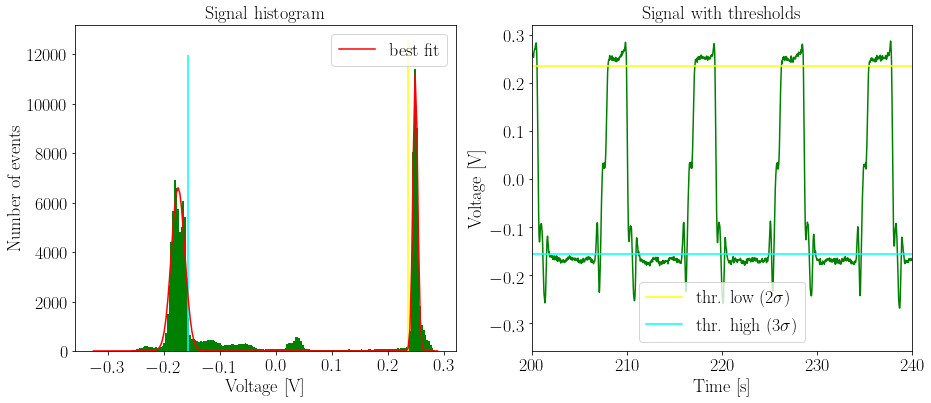

In [23]:

thr_low_2, thr_high_2, sigma_low_2, sigma_high_2 = thr_searcher(sig2_r, 200, low_sigmas=2, high_sigmas=3, Xdata=t,
                                         color='green', xlabel='Time [s]', ylabel='Voltage [V]', xmin=200, xmax=240)

## Drops detection

### Signal 1

123 123
123 123


<IPython.core.display.Javascript object>


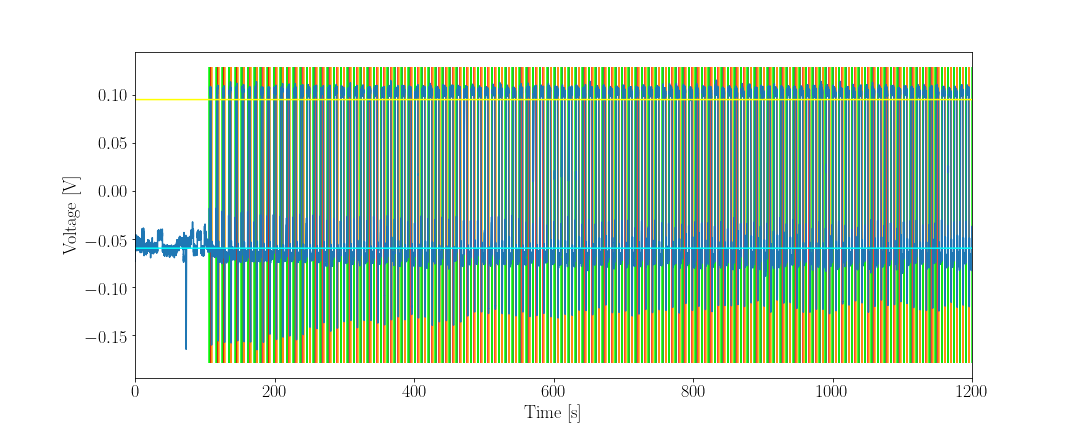

In [41]:
#****************************************
xrange = 1200 # single plot x range [s]
#****************************************

%matplotlib notebook
%matplotlib notebook

returns = ddt.drop_det_new(t, sig1_r, thr_low_1, thr_high_1, backward_skip=1, forward_skip=1, return_indexes=True,
                       xrange=xrange, plot_switch=True, xlabel="Time [s]", ylabel="Voltage [V]")

narrow_start_1, narrow_end_1, wide_start_1, wide_end_1 = returns
#function modified to give output arrays in index form, not in seconds.


### Signal 2

117 117
117 117


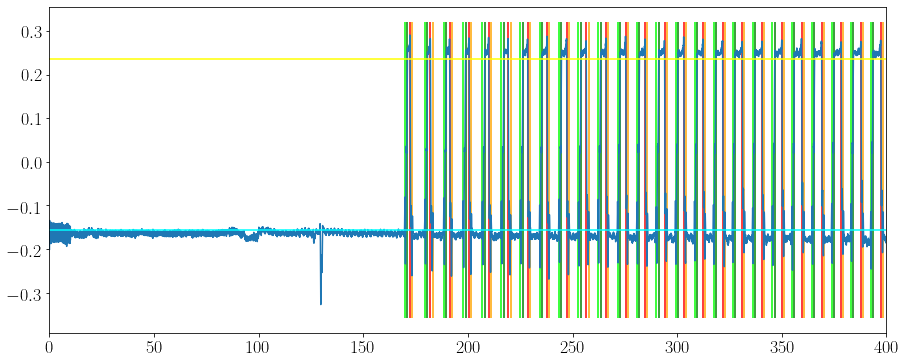

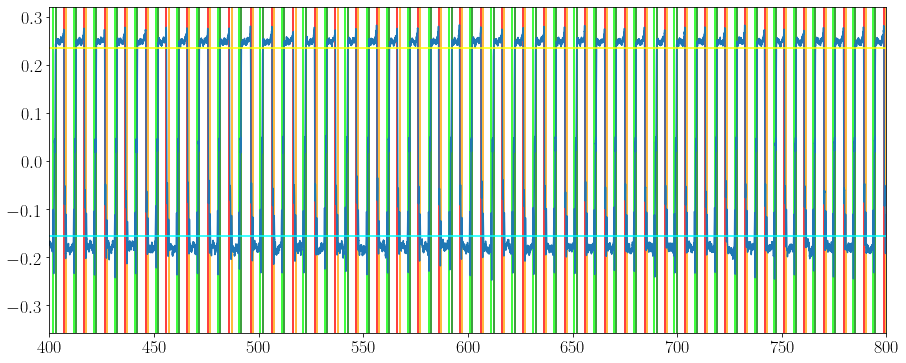

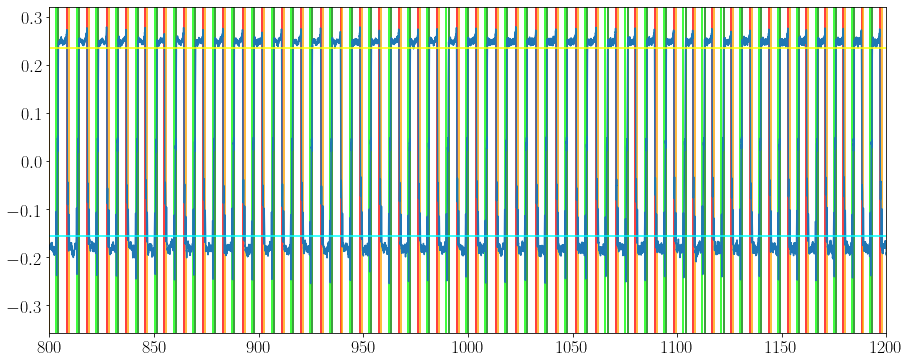

In [40]:
#****************************************
xrange = 400 # single plot x range [s]
#****************************************

%matplotlib inline
returns = ddt.drop_det_new(t, sig2_r, thr_low_2, thr_high_2, backward_skip=1, forward_skip=1, return_indexes=True,
                       xrange=xrange, plot_switch=True)

narrow_start_2, narrow_end_2, wide_start_2, wide_end_2 = returns
#function modified to give output arrays in index form, not in seconds.


## Add errors

<IPython.core.display.Javascript object>


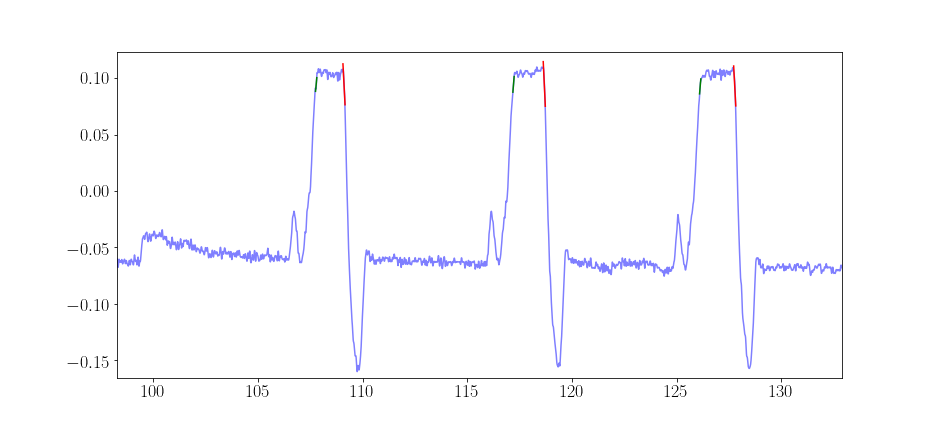

In [42]:
%matplotlib notebook
%matplotlib notebook
slope_start_1, slope_end_1=ddt.slopes(t,sig1_r, narrow_start_1, narrow_end_1, start_range=3, end_range = 5)

In [43]:
slope_start_2, slope_end_2=slopes(t,sig2_r, narrow_start_2, narrow_end_2, start_range=3, end_range = 5)

NameError: name 'slopes' is not defined

In [44]:
#slope errors for narrow_start and narrow_end
v_err_1 = sigma_high_1
err_slope_start_1 = v_err_1/slope_start_1
err_slope_end_1 = -v_err_1/slope_end_1

v_err_2 = sigma_high_2
err_slope_start_2 = v_err_2/slope_start_2
err_slope_end_2 = -v_err_2/slope_end_2


NameError: name 'slope_start_2' is not defined

In [ ]:
def res_error(time):
    a = t_raw[np.where(t_raw >= time)]
    
    return (a[1] - a[0])/np.sqrt(12)
#     return a[1] - a[0]

### Make ufloats

In [ ]:
#error resolution + error slope (seconds)
err_n_start_1=[]
err_n_end_1=[]
err_w_start_1=[]
err_w_end_1=[]
err_n_start_2=[]
err_n_end_2=[]
err_w_start_2=[]
err_w_end_2=[]

drop_edges_1 = [err_w_start_1, err_n_start_1, err_n_end_1, err_w_end_1]
drop_edges_2 = [err_w_start_2, err_n_start_2, err_n_end_2, err_w_end_2]

for drop_idx in range(len(narrow_start_1)):
    ens1 = (np.sqrt(res_error(t[narrow_start_1[drop_idx]])**2 + err_slope_start_1[drop_idx]**2))
    ene1 = (np.sqrt(res_error(t[narrow_end_1[drop_idx]])**2 + err_slope_end_1[drop_idx]**2))
    ews1 = (res_error(t[wide_start_1[drop_idx]]))
    ewe1 = (res_error(t[wide_end_1[drop_idx]]))
    
    err_n_start_1.append(unc.ufloat(t[narrow_start_1[drop_idx]],ens1))
    err_n_end_1.append(unc.ufloat(t[narrow_end_1[drop_idx]],ene1))
    err_w_start_1.append(unc.ufloat(t[wide_start_1[drop_idx]],ews1))
    err_w_end_1.append(unc.ufloat(t[wide_end_1[drop_idx]],ewe1))

for drop_idx in range(len(narrow_start_2)):
    ens2 = (np.sqrt(res_error(t[narrow_start_2[drop_idx]])**2 + err_slope_start_2[drop_idx]**2))
    ene2 = (np.sqrt(res_error(t[narrow_end_2[drop_idx]])**2 + err_slope_end_2[drop_idx]**2))
    ews2 = (res_error(t[wide_start_2[drop_idx]]))
    ewe2 = (res_error(t[wide_end_2[drop_idx]]))
    
    err_n_start_2.append(unc.ufloat(t[narrow_start_2[drop_idx]],ens2))
    err_n_end_2.append(unc.ufloat(t[narrow_end_2[drop_idx]],ene2))
    err_w_start_2.append(unc.ufloat(t[wide_start_2[drop_idx]],ews2))
    err_w_end_2.append(unc.ufloat(t[wide_end_2[drop_idx]],ewe2))
    

drop_edges_1 = [np.array(e) for e in drop_edges_1]
drop_edges_2 = [np.array(e) for e in drop_edges_2]

err_w_start_1, err_n_start_1, err_n_end_1, err_w_end_1 = drop_edges_1
err_w_start_2, err_n_start_2, err_n_end_2, err_w_end_2 = drop_edges_2

to_adjust = True

## Delay between detectors

In [ ]:
# spannometric estimation of the time interval between the drops, knowing the pumps fluxes and capillary size

#********************************************************
radius  = 0.3  # capillary radius [mm]
sep     = 50   # spearation between the two sensors [mm]
flux_ol = 2    # oil flux   [uL/min] = [mm3/min]
flux_aq = 2    # water flux [uL/min] = [mm3/min]
#********************************************************

A  = np.pi*0.25*radius**2       # capillary area [mm2]
v  = (flux_ol + flux_aq)/A/60   # drops speed [mm/s]
dt = sep/v                      # time interval between two following drops [s]

print('v  = ', v,'\t[mm/s] \ndt = ', dt, '\t[s]')

In [ ]:
#this function calculates delay between sig1 and sig2 by spectra smoothing (delay_gauss) 
#and by simple spectra subtraction (delay_spectra)
    
def delay(sigma, delta, delta_delay, step_delay, start_time, stop_time, step_time, vec1, vec2, signal1, signal2,
          min_cut_idx=0, max_cut_idx=5000):   
    
    
    # Gaussian formula ---------------------------------------

    q = np.sqrt(2*np.pi)
    def gaus(x, mu, sigma):
        return np.exp(-(x - mu)**2/(2*sigma**2))/(sigma*q)

    
    # Gaussian smoothing functions ---------------------------

    # Signal 1
    @np.vectorize
    def sig1_smooth(t, sigma, delta):
        s = 0.
        for t_s in vec1:
            if (t - t_s)**2 < (delta*sigma)**2:
                s += gaus(t,t_s,sigma)
            if t_s - t > (delta+1)*sigma:
                break
        return s
    
    # Signal 2
    @np.vectorize
    def sig2_smooth(t, sigma, delta):
        s = 0.
        for t_s in vec2:
            if (t - t_s)**2 < (delta*sigma)**2:
                s += gaus(t,t_s,sigma)
            if t_s - t > (delta+1)*sigma:
                break
        return s


    # Delay computing ::::::::::::::::::::::::::::::::::::::::::::
    
    start_delay = dt - delta_delay                                # initial evaluated delay [s]
    stop_delay  = dt + delta_delay                                # final evaluated delay [s]
    time_delays = np.arange(start_delay, stop_delay, step_delay)  # vector of evaluated delays [s]
    ts          = np.arange(start_time,  stop_time,  step_time)   # vector of scanned times [s]
    msqs        = []                                              # stdev between sig.1 and sig.2 delayed 

    
    # Computing delay_gauss --------------------------------------
    
    for time_delay in tqdm(time_delays):

        sig1_t = sig1_smooth(ts, sigma, delta)
        sig2_t = sig2_smooth(ts + time_delay, sigma, delta)
        msqs.append(np.mean((sig2_t - sig1_t)**2))

    msqs=np.array(msqs)
    delay_gauss=time_delays[msqs==min(msqs)]
    
    
    # Delay with spectra-subtraction -----------------------------
    
    delay_idxs = np.arange(int(start_delay*100), int(stop_delay*100))
    msqs1 = []

    for idx in delay_idxs:
            #sig1_cut = sig1_high[:len(sig2_high) - idx][start_time*100:stop_time*100]
            #sig2_cut = sig2_high[idx:][start_time*100:stop_time*100]
            sig1_cut = signal1[:len(signal2) - idx][min_cut_idx:max_cut_idx]
            sig2_cut = signal2[idx:][min_cut_idx:max_cut_idx]
            msqs1.append(np.mean((sig1_cut - sig2_cut)**2))
    msqs1=np.array(msqs1)
    delay_spectra=t[delay_idxs[[msqs1==min(msqs1)]]] 
   

    # Plots ------------------------------------------------------
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))    
    ax[0].set_title('Delay spectrum from gaussian broadening')
    ax[0].set_xlabel("delay [s]")
    ax[0].set_ylabel("msqs")
    ax[0].plot(time_delays,msqs)
    ax[1].set_title('Delay spectrum from signal subtraction')
    ax[1].set_xlabel("Delay [s]")
    ax[1].set_ylabel("msqs")
    ax[1].set_xlim(*ax[0].get_xlim())
    ax[1].plot(t[delay_idxs],msqs1)
    fig.tight_layout()
    
    #define the number of initial drops to be neglected in sig2 
    neglected_drops_2 = vec2[vec2<delay_spectra]
    d2 = len(neglected_drops_2)    
          
    return delay_gauss, delay_spectra, d2

In [ ]:
#*********************************************************************************************
# Signal gaussian smoothing
sigma       = 0.01   # stdev
delta       = 2      # range = delta*stdev
# Delay
delta_delay = 20      # range of evaluated delays = [dt - delta_delay ; dt + delta_delay] [s]
step_delay  = 0.05   # step of evaluated delays [s]
# Time
start_time  = 100     # scanning signal starting time [s]
stop_time   = 120     # scanning signal stopping time [s]
step_time   = 0.005  # scanning signal step time [s]

vec1 = np.array([d.n for d in err_w_start_1])
vec2 = np.array([d.n for d in err_w_start_2])

signal1 = sig1_r
signal2 = sig2_r
#*********************************************************************************************

delay_gauss, delay_spectra, d2 = delay(sigma, delta, delta_delay, step_delay, start_time, stop_time, step_time,
                                       vec1, vec2, signal1, signal2,
                                       min_cut_idx=5000, max_cut_idx = 20000)

delay_gauss, delay_spectra, d2

### Manually check the delay

In [ ]:
def align(delay):
    
    delay_idx = int(delay*100)
    
    fig, ax1 = plt.subplots(figsize=(9,6))
    
    ax1.plot(t, sig1_r, color='blue', alpha=0.3)
    
    ax2 = ax1.twinx()
    
    ax2.plot(t[:-delay_idx], sig2_r[delay_idx:], color='red', alpha=0.3)
    

In [ ]:
reload(plt)

In [ ]:
%matplotlib notebook
%matplotlib notebook

align(55)

## Adjust drops according to delay

In [ ]:
#decide whether to use calculated d2 or to set it by hand
#d2 = 
def adjust_drops(d1,d2, drop_edges_1, drop_edges_2):
    
    drop_edges_1 = [d[d1:] for d in drop_edges_1]
    drop_edges_2 = [d[d1 + d2:] for d in drop_edges_2]
    
    len2 = len(drop_edges_2[0])
    drop_edges_1 = [d[:len2] for d in drop_edges_1]
    
    return drop_edges_1, drop_edges_2

In [ ]:
#THIS FUNCTION MODIFIES drop_start and drop_end s arrays

d1 = 0          #d1>0 to discard some initial drops that are present in both signals
#d2 = 0
if to_adjust:
    drop_edges_1,drop_edges_2 = adjust_drops(d1,d2, drop_edges_1, drop_edges_2)

    err_w_start_1, err_n_start_1, err_n_end_1, err_w_end_1 = drop_edges_1
    err_w_start_2, err_n_start_2, err_n_end_2, err_w_end_2 = drop_edges_2
    
    to_adjust = False

## Define variables of interest


Arrays  contain wide in first element, narrow in second element

In [ ]:
#mid point (in seconds)
mid_1 = [0.5*(err_w_start_1+err_w_end_1),0.5*(err_n_start_1+err_n_end_1)]
mid_2 = [0.5*(err_w_start_2+err_w_end_2),0.5*(err_n_start_2+err_n_end_2)]

#drops distances in the same channel
distance_1 = [- err_w_end_1[:-1] + err_w_start_1[1:], - err_n_end_1[:-1] + err_n_start_1[1:]]
distance_2 = [- err_w_end_2[:-1] + err_w_start_2[1:], - err_n_end_2[:-1] + err_n_start_2[1:]]

#temporal size
size_1 = [err_w_end_1 - err_w_start_1,err_n_end_1 - err_n_start_1]
size_2 = [err_w_end_2 - err_w_start_2, err_n_end_2 - err_n_start_2]

dt_mid = [mid_2[0] - mid_1[0], mid_2[1] - mid_1[1]]
v_mid = [50/dt_mid[0],50/dt_mid[1]]

period_1 = [mid_1[0][1:]-mid_1[0][:-1],mid_1[1][1:]-mid_1[1][:-1]]
period_2 = [mid_2[0][1:]-mid_2[0][:-1],mid_2[1][1:]-mid_2[1][:-1]]


# PLOTTING

Variables have wide version in first element, wide version in second element.
Use parameter which = 0 for wide, which = 1 for narrow

## Temporal distance between drops in the same signal 

In [ ]:
def time_dist(bins, distance_1, distance_2, which=0):
    
    #reload(uplt)
    fig = plt.figure(figsize=(10,7))
    gs = GridSpec(4,5)

    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_y_1 = fig.add_subplot(gs[1:4,3])
    ax_marg_y_2 = fig.add_subplot(gs[1:4,4])

    uplt.plot(distance_1[which], ax = ax_joint, label='sig1')
    uplt.plot(distance_2[which], ax = ax_joint, color='green', label='sig2')

    k1=uplt.ExtendedKDE(distance_1[which]) 
    ylim=ax_joint.get_ylim()
    k1(np.linspace(ylim[0],ylim[1],bins))
    k1.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x1,f1 = k1.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_1, switch_xy=True)

    k2=uplt.ExtendedKDE(distance_2[which]) 
    ylim=ax_joint.get_ylim()
    k2(np.linspace(ylim[0],ylim[1],bins))
    k2.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x2,f2 = k2.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_2, switch_xy=True, color='green')

    #Turn off tick labels on marginals
    plt.setp(ax_marg_y_1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y_2.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('distances [s]')

    ax_joint.legend(loc='best')
    plt.title('Temporal distance between drops in the same signal, as a function of drop id number',loc='right', pad=15)

    #kde fit

    mod1 = GaussianModel(prefix='g1_')
    pars1 = mod1.guess(f1, x=x1)
    out1 = mod1.fit(f1, pars1, x=x1)
    ax_marg_y_1.plot(out1.best_fit, x1, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')

    mod2 = GaussianModel(prefix='g2_')
    pars2 = mod2.guess(f1, x=x2)
    out2 = mod2.fit(f2, pars2, x=x2)
    ax_marg_y_2.plot(out1.best_fit, x2, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')

    fig.tight_layout()
    plt.show()

    dist1 = out1.best_values.get('g1_center')
    sigma_dist1 = out1.best_values.get('g1_sigma')

    dist2 = out2.best_values.get('g2_center')
    sigma_dist2 = out2.best_values.get('g2_sigma')

    return fig, dist1, sigma_dist1, dist2, sigma_dist2


In [ ]:
#*************
subname = ''
bins    = 70
#*************

fig, dist1_w, sigma_dist1_w, dist2_w, sigma_dist2_w = time_dist(bins, distance_1, distance_2, which=0)

# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

In [ ]:
#*************
subname = ''
bins    = 70
#*************

fig, dist1_n, sigma_dist1_n, dist2_n, sigma_dist2_n = time_dist(bins, distance_1, distance_2, which=1)

# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

## Temporal size 

In [ ]:
def time_size(bins, size_1, size_2, which=0):
    
    #reload(uplt)
    fig = plt.figure(figsize=(10,7))
    gs = GridSpec(4,5)

    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_y_1 = fig.add_subplot(gs[1:4,3])
    ax_marg_y_2 = fig.add_subplot(gs[1:4,4])

    uplt.plot(size_1[which], ax = ax_joint, label='sig1')
    uplt.plot(size_2[which], ax = ax_joint, color='green', label='sig2')

    k1=uplt.ExtendedKDE(size_1[which]) 
    ylim=ax_joint.get_ylim()
    k1(np.linspace(ylim[0],ylim[1],bins))
    k1.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x1,f1 = k1.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_1, switch_xy=True)

    k2=uplt.ExtendedKDE(size_2[which]) 
    ylim=ax_joint.get_ylim()
    k2(np.linspace(ylim[0],ylim[1],bins))
    k2.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x2,f2 = k2.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_2, switch_xy=True, color='green')

    #Turn off tick labels on marginals
    plt.setp(ax_marg_y_1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y_2.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('sizes [s]')

    ax_joint.legend(loc='best')
    plt.title('Temporal size of drops in each signal, as a function of drop id number',loc='right', pad=15)

    #kde fit

    mod1 = GaussianModel(prefix='g1_')
    pars1 = mod1.guess(f1, x=x1)
    out1 = mod1.fit(f1, pars1, x=x1)
    ax_marg_y_1.plot(out1.best_fit, x1, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')

    mod2 = GaussianModel(prefix='g2_')
    pars2 = mod2.guess(f1, x=x2)
    out2 = mod2.fit(f2, pars2, x=x2)
    ax_marg_y_2.plot(out1.best_fit, x2, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')

    fig.tight_layout()
    plt.show()

    t_size1 = out1.best_values.get('g1_center')
    sigma_t_size1 = out1.best_values.get('g1_sigma')

    t_size2 = out2.best_values.get('g2_center')
    sigma_t_size2 = out2.best_values.get('g2_sigma')

    return fig, t_size1, sigma_t_size1, t_size2, sigma_t_size2 


In [ ]:
#*************
subname = ''
bins    = 100
#*************

fig, t_size1_w, sigma_t_size1_w, t_size2_w, sigma_t_size2_w = time_size(bins, size_1, size_2, which=0)

# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

In [ ]:
#*************
subname = ''
bins    = 100
#*************

fig, t_size1_n, sigma_t_size1_n, t_size2_n, sigma_t_size2_n = time_size(bins, size_1, size_2, which=1)

# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

## Time separation between detectors and drop velocity

In [ ]:
def dt_vel(bins,dt_mid,v_mid,which=0):
    
    fig = plt.figure(figsize=(10,7.5))

    gs = GridSpec(8,4)
    #first plot
    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])

    uplt.plot(dt_mid[which], ax = ax_joint, label='time interval')  
    
    k1=uplt.ExtendedKDE(dt_mid[which]) 
    ylim=ax_joint.get_ylim()
    k1(np.linspace(ylim[0],ylim[1],bins))
    k1.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x1,f1 = k1.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y, switch_xy=True)

    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('detectors time interval [s]')

    plt.title('Temporal delay of drops in the detectors and drop velocity',loc='right', pad=15)

    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    #second plot
    ax1_joint = fig.add_subplot(gs[5:8,0:3])
    ax1_marg_y = fig.add_subplot(gs[5:8,3])

    uplt.plot(0.5*(mid_1[which]+mid_2[which]),v_mid[which], ax=ax1_joint, label='velocity', color='green')
    k2=uplt.ExtendedKDE(v_mid[which]) 
    ylim=ax1_joint.get_ylim()
    k2(np.linspace(ylim[0],ylim[1],bins))
    k2.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x2,f2 = k2.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax1_marg_y, switch_xy=True, color='green')


    ax1_joint.set_xlabel('time (drop equidistant from detectors) [s]')
    ax1_joint.set_ylabel('drops velocity [mm/s]')

    plt.setp(ax1_marg_y.get_yticklabels(), visible=False)
    
    #Turn off tick labels on marginals
    plt.setp(ax1_marg_y.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

       
    fig.tight_layout()
    plt.show()

    
    return fig

In [ ]:
#************
subname = ''
bins    = 60
#************
reload(uplt)
fig = dt_vel(bins, dt_mid, v_mid,which=0)

# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

In [ ]:
#************
subname = ''
bins    = 60
#************
reload(uplt)
fig = dt_vel(bins, dt_mid, v_mid,which=1)

# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

## Spatial size

In [ ]:
def space_size(bins, space_size_1, space_size_2, v_mid,which=0):
    
    reload(uplt)
    fig = plt.figure(figsize=(10,7))
    gs = GridSpec(4,5)
    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_y_1 = fig.add_subplot(gs[1:4,3])
    ax_marg_y_2 = fig.add_subplot(gs[1:4,4])

    uplt.plot(size_1[which]*v_mid[which], ax = ax_joint, label='sig1')
    uplt.plot(size_2[which]*v_mid[which], ax = ax_joint, color='green', label='sig2')

    k1=uplt.ExtendedKDE(size_1[which]*v_mid[which]) 
    ylim=ax_joint.get_ylim()
    k1(np.linspace(ylim[0],ylim[1],bins))
    k1.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x1,f1 = k1.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_1, switch_xy=True)

    k2=uplt.ExtendedKDE(size_2[which]*v_mid[which]) 
    ylim=ax_joint.get_ylim()
    k2(np.linspace(ylim[0],ylim[1],bins))
    k2.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x2,f2 = k2.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_2, switch_xy=True, color='green')

    #Turn off tick labels on marginals
    plt.setp(ax_marg_y_1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y_2.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('sizes [s]')

    ax_joint.legend(loc='best')
    plt.title('Spatial size of drops in each signal, as a function of drop id number',loc='right', pad=15)

    #kde fit

    mod1 = GaussianModel(prefix='g1_')
    pars1 = mod1.guess(f1, x=x1)
    out1 = mod1.fit(f1, pars1, x=x1)
    ax_marg_y_1.plot(out1.best_fit, x1, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')

    mod2 = GaussianModel(prefix='g2_')
    pars2 = mod2.guess(f1, x=x2)
    out2 = mod2.fit(f2, pars2, x=x2)
    ax_marg_y_2.plot(out1.best_fit, x2, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')

    fig.tight_layout()
    plt.show()

    size1 = out1.best_values.get('g1_center')
    sigma_size1 = out1.best_values.get('g1_sigma')

    size2 = out2.best_values.get('g2_center')
    sigma_size2 = out2.best_values.get('g2_sigma')
    
    return fig, size1, sigma_size1, size2, sigma_size2

In [ ]:
#*****************************
subname = 'spatial_size'
bins    = 80
#*****************************

fig, size1_w, sigma_size1_w, size2_w, sigma_size2_w  = space_size(bins, size_1, size_2, v_mid, which=0)

#fig.savefig(f'{plot_dir}/{name}_{subname}.png')

In [ ]:
#*****************************
subname = 'spatial_size'
bins    = 80
#*****************************

fig, size1_n, sigma_size1_n, size2_n, sigma_size2_n  = space_size(bins, size_1, size_2, v_mid, which=1)

#fig.savefig(f'{plot_dir}/{name}_{subname}.png')

## Period between adiacent drops

In [ ]:
def period(bins, period_1, period_2, which=0):
    
    reload(uplt)
    fig = plt.figure(figsize=(10,7))
    gs = GridSpec(4,5)
    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_y_1 = fig.add_subplot(gs[1:4,3])
    ax_marg_y_2 = fig.add_subplot(gs[1:4,4])

    uplt.plot(period_1[which], ax = ax_joint, label='sig1')
    uplt.plot(period_2[which], ax = ax_joint, color='green', label='sig2')

    k1=uplt.ExtendedKDE(period_1[which]) 
    ylim=ax_joint.get_ylim()
    k1(np.linspace(ylim[0],ylim[1],bins))
    k1.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x1,f1 = k1.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_1, switch_xy=True)

    k2=uplt.ExtendedKDE(period_2[which]) 
    ylim=ax_joint.get_ylim()
    k2(np.linspace(ylim[0],ylim[1],bins))
    k2.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x2,f2 = k2.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_2, switch_xy=True, color='green')

    #Turn off tick labels on marginals
    plt.setp(ax_marg_y_1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y_2.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('period [s]')

    ax_joint.legend(loc='best')
    plt.title('Drops period in each signal, as a function of drop id number',loc='right', pad=15)

    #kde fit

    mod1 = GaussianModel(prefix='g1_')
    pars1 = mod1.guess(f1, x=x1)
    out1 = mod1.fit(f1, pars1, x=x1)
    ax_marg_y_1.plot(out1.best_fit, x1, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')

    mod2 = GaussianModel(prefix='g2_')
    pars2 = mod2.guess(f1, x=x2)
    out2 = mod2.fit(f2, pars2, x=x2)
    ax_marg_y_2.plot(out1.best_fit, x2, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')

    fig.tight_layout()
    plt.show()

    period1 = out1.params.get('g1_center')
    sigma_period1 = out1.params.get('g1_sigma')

    period2 = out2.params.get('g2_center')
    sigma_period2 = out2.params.get('g2_sigma')  
    
    return fig, period1, sigma_period1, period2, sigma_period2

In [ ]:
#*****************************
subname = 'spatial_size'
bins    = 80
#*****************************
bins = 50
fig, period1_w, sigma_period1_w, period2_w, sigma_period2_w = period(bins, period_1, period_2, which=0)

#fig.savefig(f'{plot_dir}/{name}_{subname}.png')

In [ ]:
#*****************************
subname = 'spatial_size'
bins    = 80
#*****************************
bins = 50
fig, period1_n, sigma_period1_n, period2_n, sigma_period2_n = period(bins, period_1, period_2, which=1)

#fig.savefig(f'{plot_dir}/{name}_{subname}.png')

## Save fit parameters to file

In [ ]:
a='parameters'
with open(f'{plot_dir}/{a}_{name}.csv', mode='w', newline ='') as file:
    writer = csv.writer(file, delimiter='	', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    s = ['file containing parameters from fit: center_1, sigma_1, center_2, sigma_2']
    writer.writerow(s)
    a = ['spatial size wide (mm)',size1_w, sigma_size1_w, size2_w, sigma_size2_w]
    writer.writerow(a)
    a1 = ['spatial size narrow (mm)',size1_n, sigma_size1_n, size2_n, sigma_size2_n]
    writer.writerow(a1)
    b = ['temporal size wide (s)',t_size1_w, sigma_t_size1_w, t_size2_w, sigma_t_size2_w]
    writer.writerow(b)
    b1 = ['temporal size narrow (s)',t_size1_n, sigma_t_size1_n, t_size2_n, sigma_t_size2_n]
    writer.writerow(b1)
    c = ['temporal distance wide (mm)',dist1_w, sigma_dist1_w, dist2_w, sigma_dist2_w]
    writer.writerow(c)
    c1 = c1 = ['temporal distance narrow (mm)',dist1_n, sigma_dist1_n, dist2_n, sigma_dist2_n]
    writer.writerow(c1)
    d = ['period wide (s)',period1_w, sigma_period1_w, period2_w, sigma_period2_w]
    writer.writerow(d)
    d1 = ['period narrow (s)',period1_n, sigma_period1_n, period2_n, sigma_period2_n]
    writer.writerow(d1)
    